In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

!pip install metric-learn

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import MMC_Supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 793.3 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import scipy.io
data = scipy.io.loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU.mat')['paviaU']
gt = scipy.io.loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU_gt.mat')['paviaU_gt']

def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX

data=applyPCA(data)

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df['class'] = gt.ravel()

X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values



In [4]:


acc_list = []

kf = KFold(n_splits=5, shuffle=True,random_state=42)

mmc = MMC_Supervised(n_constraints=5,verbose=True)
knn = KNeighborsClassifier(n_neighbors=5)

f_index = 1
for train_index, test_index in kf.split(X):
    print(f"Fold {f_index} -> Train: {len(train_index)}, Test: {len(test_index)}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mmc.fit(X_train, y_train)
    knn.fit(mmc.transform(X_train), y_train)


    mmc_acc = knn.score(mmc.transform(X_test), y_test)
    print('mmc accuracy  {}'.format(mmc_acc))

    acc_list.append(mmc_acc)

    f_index += 1

print("Ortalaması Başarı:", np.mean(acc_list))
print("Standart sapma:",np.std(acc_list) )

Fold 1 -> Train: 34220, Test: 8556
mmc iter: 0, conv = 0.033128, projections = 674
mmc iter: 1, conv = 0.034251, projections = 321
mmc iter: 2, conv = 0.035372, projections = 324
mmc iter: 3, conv = 0.036486, projections = 315
mmc iter: 4, conv = 0.037590, projections = 304
mmc iter: 5, conv = 0.038680, projections = 295
mmc iter: 6, conv = 0.039753, projections = 288
mmc iter: 7, conv = 0.040804, projections = 283
mmc iter: 8, conv = 0.041831, projections = 279
mmc iter: 9, conv = 0.042831, projections = 276
mmc iter: 10, conv = 0.043802, projections = 274
mmc iter: 11, conv = 0.044740, projections = 273
mmc iter: 12, conv = 0.045655, projections = 488
mmc iter: 13, conv = 0.046552, projections = 624
mmc iter: 14, conv = 0.047426, projections = 747
mmc iter: 15, conv = 0.048277, projections = 870
mmc iter: 16, conv = 0.049104, projections = 986
mmc iter: 17, conv = 0.049906, projections = 1093
mmc iter: 18, conv = 0.050680, projections = 1191
mmc iter: 19, conv = 0.051427, projections

In [6]:
import joblib

joblib.dump(mmc, 'mmc_pavia_model.pkl')
joblib.dump(knn,'mmc_pavia_knn_model.pkl')

mmc_loaded = joblib.load('mmc_pavia_model.pkl')
knn_loaded =joblib.load('mmc_pavia_knn_model.pkl')

mmc_data=mmc_loaded.transform(X)
pred=knn_loaded.predict(mmc_data)

In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

print("accuracy:",accuracy_score(pred,y))
print("cohen kappa:", cohen_kappa_score(pred,y))
print("f1 score:",f1_score(pred,y,average='macro'))

In [7]:
gt_2 = gt.copy()
gt_2=gt_2.reshape(-1)


i = 0
j=0
while(i<(gt.shape[0]*gt.shape[1])):
      if(gt_2[i] != 0):
          gt_2[i]=pred[j]
          j += 1
      i += 1

In [8]:
gt_2=gt_2.reshape(data.shape[0],-1)

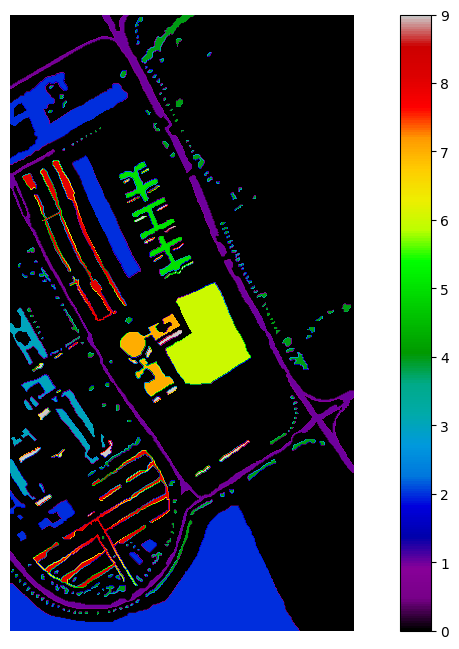

In [9]:
def plot_gt(data):
  fig = plt.figure(figsize=(12, 8))
  plt.imshow(data,cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_gt(gt)

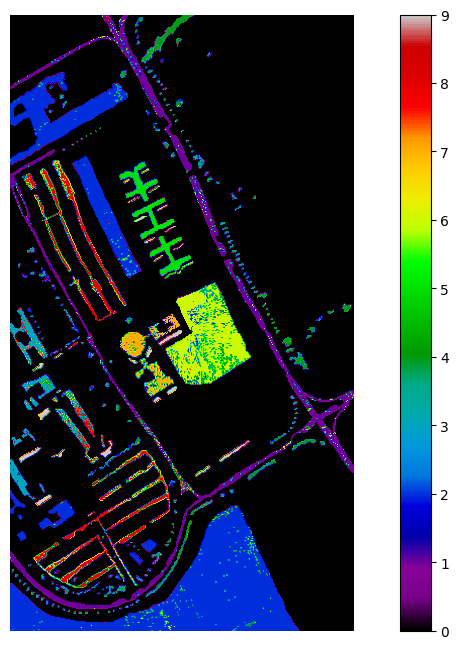

In [10]:
plot_gt(gt_2)